In [117]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


from tensorflow import keras
from sklearn.model_selection import train_test_split

In [118]:

batch_size = 100
x_data_dim = 4

data_dir = '/content/drive/MyDrive/영우_4기_딥러닝/answer/dataset'

fname = os.path.join(data_dir, 'a_company_stock.csv')

In [144]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv(fname)

columns = df.columns

sca = MinMaxScaler()

df= pd.DataFrame(sca.fit_transform(df))
df.columns = columns
df



,Open,High,Low,Close,Volume
0,0.230769,0.236404,0.249861,0.241360,0.163701
1,0.237963,0.237514,0.239335,0.221851,0.195529
2,0.233536,0.236404,0.240997,0.241360,0.175595
3,0.234643,0.237514,0.252632,0.240803,0.168330
4,0.240177,0.237514,0.243213,0.232999,0.123827
...,...,...,...,...,...
1220,0.607084,0.609600,0.606371,0.605072,0.147357
1221,0.600166,0.599889,0.598061,0.591137,0.209069
1222,0.532374,0.556881,0.550970,0.547938,0.298976
1223,0.546209,0.549945,0.546814,0.547938,0.222844


In [145]:
ori_x = df[['Open','High','Low','Volume']]
ori_y = df['Close']

In [146]:
seq_length= 8
x_data_dim=4
batch_size= 100
min_max_normalization_flag= False

x_train, x_test, y_train, y_test  = train_test_split(ori_x, ori_y, test_size = 0.2, shuffle = False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size  = 0.2, shuffle = False)

In [147]:
x_train.shape, x_val.shape, x_test.shape

((784, 4), (196, 4), (245, 4))

In [148]:
dataset_y = y_train.describe()
dataset_y = dataset_y.transpose()

In [149]:
## 데이터의 min , max, mean, std 값 구하기.
dataset_stats = x_train.describe()
dataset_stats = dataset_stats.transpose()

## data normalization
## data normalization
def min_max_norm(x):
  return (x - dataset_stats['min']) / (dataset_stats['max'] - dataset_stats['min'])

def standard_norm(x):
  return (x - dataset_stats['mean']) / dataset_stats['std']

def y_norm(y):
  return (y - dataset_y['min']) / (dataset_y['max'] - dataset_y['min'])

if min_max_normalization_flag==True:
    min_max_norm_train_data = min_max_norm(x_train)
    min_max_norm_val_data = min_max_norm(x_val)
    min_max_norm_test_data = min_max_norm(x_test)
    min_max_norm_y_train = y_norm(y_train)
    min_max_norm_y_val = y_norm(y_val)
    min_max_norm_y_test = y_norm(y_test)

    data_gen_train=tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_train_data.values.tolist(),min_max_norm_y_train.values.tolist(),
                                                                        length=seq_length, sampling_rate=1,
                                                                        batch_size=batch_size)
    data_gen_val=tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_val_data.values.tolist(),min_max_norm_y_val.values.tolist(),
                                                                       length=seq_length, sampling_rate=1,
                                                                       batch_size=batch_size)
    data_gen_test=tf.keras.preprocessing.sequence.TimeseriesGenerator(min_max_norm_test_data.values.tolist(),min_max_norm_y_test.values.tolist(),
                                                                       length=seq_length, sampling_rate=1,
                                                                       batch_size=batch_size)
else:
    data_gen_train = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train.values.tolist(),y_train.values.tolist(),
                                                                   length=seq_length, sampling_rate=1,
                                                                   batch_size=batch_size)
    data_gen_val = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_val.values.tolist(),y_val.values.tolist(),
                                                                   length=seq_length, sampling_rate=1,
                                                                   batch_size=batch_size)
    data_gen_test = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test.values.tolist(),y_test.values.tolist(),
                                                                        length=seq_length, sampling_rate=1,
                                                                        batch_size=batch_size)

# Simple RNN

In [172]:
input_layer = keras.layers.Input(shape = (seq_length, x_data_dim))
x =  keras.layers.SimpleRNN(50,activation = 'tanh')(input_layer)
x = keras.layers.Dense(100,activation = 'relu')(x)
x = keras.layers.Dense(50,activation = 'relu')(x)
out_layer = keras.layers.Dense(1,activation = None)(x)

model = keras.Model(inputs = [input_layer], outputs = [out_layer])
print(model.summary())

model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001) ,  loss= 'mse',metrics = [keras.metrics.mean_absolute_error])


epoch = 500
batch_size = 100
es = keras.callbacks.EarlyStopping(monitor = 'val_loss')
cp = keras.callbacks.ModelCheckpoint('/content/model/predict_stock_2.h5',monitor = 'val_loss',save_best_only = True)


history = model.fit(data_gen_train, epochs = epoch,batch_size =batch_size,verbose  = 1, validation_data = data_gen_val)

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 8, 4)]            0         
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 50)                2750      
_________________________________________________________________
dense_97 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_98 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 51        
Total params: 12,951
Trainable params: 12,951
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
8/8 [==============================] - 1s 53ms/step - loss: 0.0039 - mean_absolute_error: 0.0487 - val_

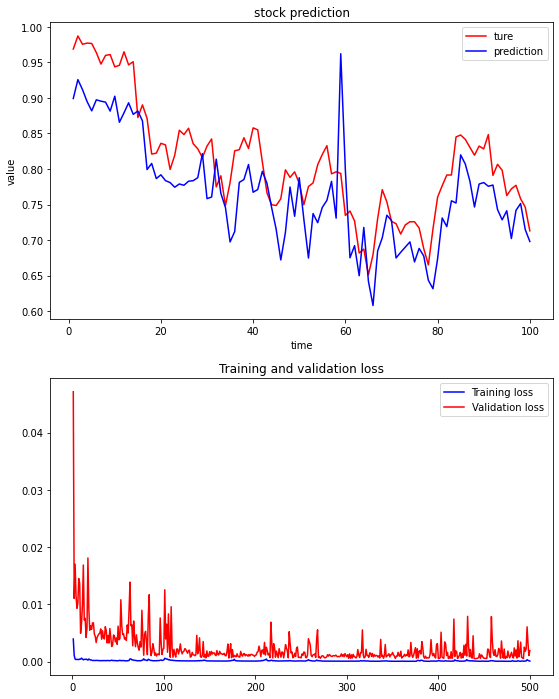

In [173]:
test_data_X, test_data_Y=data_gen_test[0]
prediction_Y=model.predict(test_data_X).flatten()
Y_test=test_data_Y.flatten()

visual_y=[]
visual_pre_y=[]
for i in range(len(prediction_Y)):
    label = Y_test[i]
    prediction = prediction_Y[i]
    visual_y.append(label)
    visual_pre_y.append(prediction)
plt.figure(figsize = (9,12))
time = range(1, len(visual_y) + 1)
plt.subplot(2,1,1)
plt.plot(time, visual_y, 'r', label='ture')
plt.plot(time, visual_pre_y, 'b', label='prediction')
plt.title('stock prediction')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### GRU

In [176]:
input_layer = keras.layers.Input(shape = (seq_length, 4))
x =  keras.layers.GRU(50,activation = 'tanh')(input_layer)
x = keras.layers.Dense(100,activation = 'relu')(x)
x = keras.layers.Dense(50,activation = 'relu')(x)
out_layer = keras.layers.Dense(1,activation = None)(x)

model_2 = keras.Model(inputs = [input_layer], outputs = [out_layer])
model_2.summary()

model_2.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001) ,  loss= 'mse',metrics = [keras.metrics.mean_absolute_error])

epoch = 500
batch_size = 100

history_2 = model_2.fit(data_gen_train, epochs = epoch, verbose  = 1, validation_data = data_gen_val)

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 8, 4)]            0         
_________________________________________________________________
gru_11 (GRU)                 (None, 50)                8400      
_________________________________________________________________
dense_103 (Dense)            (None, 100)               5100      
_________________________________________________________________
dense_104 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 51        
Total params: 18,601
Trainable params: 18,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
8/8 [==============================] - 3s 82ms/step - loss: 0.0044 - mean_absolute_error: 0.0540 - val_loss:

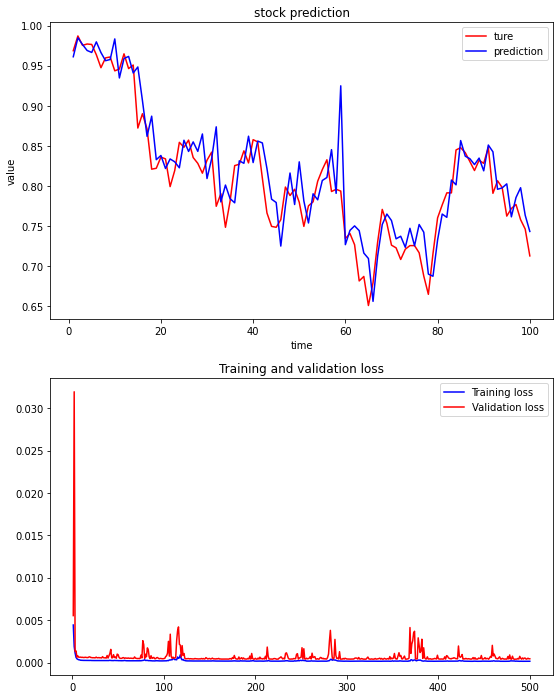

In [177]:
test_data_X, test_data_Y=data_gen_test[0]
prediction_Y=model_2.predict(test_data_X).flatten()
Y_test=test_data_Y.flatten()

visual_y=[]
visual_pre_y=[]
for i in range(len(prediction_Y)):
    label = Y_test[i]
    prediction = prediction_Y[i]
    visual_y.append(label)
    visual_pre_y.append(prediction)
plt.figure(figsize = (9,12))
time = range(1, len(visual_y) + 1)
plt.subplot(2,1,1)
plt.plot(time, visual_y, 'r', label='ture')
plt.plot(time, visual_pre_y, 'b', label='prediction')
plt.title('stock prediction')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## LSTM

In [178]:
input_layer = keras.layers.Input(shape = (seq_length, 4))
x =  keras.layers.LSTM(50,activation = 'tanh')(input_layer)
x = keras.layers.Dense(100,activation = 'relu')(x)
x = keras.layers.Dense(50,activation = 'relu')(x)
out_layer = keras.layers.Dense(1,activation = None)(x)

model_4= keras.Model(inputs = [input_layer], outputs = [out_layer])
model_4.summary()


model_4.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),  loss= 'mse',metrics = [keras.metrics.mean_absolute_error])
epoch = 500
batch_size = 100


history_4 = model_4.fit(data_gen_train, epochs = epoch, verbose  = 1, validation_data = data_gen_val)

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 8, 4)]            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 50)                11000     
_________________________________________________________________
dense_106 (Dense)            (None, 100)               5100      
_________________________________________________________________
dense_107 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 51        
Total params: 21,201
Trainable params: 21,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
8/8 [==============================] - 3s 84ms/step - loss: 0.0146 - mean_absolute_error: 0.0951 - val_loss:

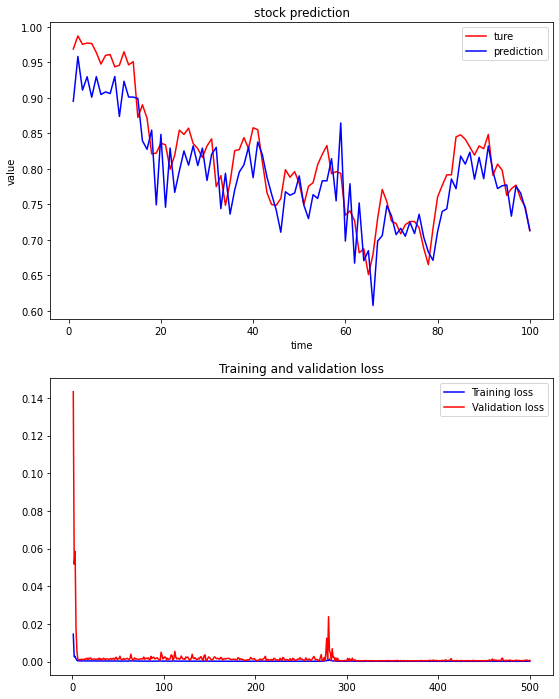

In [179]:
test_data_X, test_data_Y=data_gen_test[0]
prediction_Y=model_4.predict(test_data_X).flatten()
Y_test=test_data_Y.flatten()

visual_y=[]
visual_pre_y=[]
for i in range(len(prediction_Y)):
    label = Y_test[i]
    prediction = prediction_Y[i]
    visual_y.append(label)
    visual_pre_y.append(prediction)
plt.figure(figsize = (9,12))
time = range(1, len(visual_y) + 1)
plt.subplot(2,1,1)
plt.plot(time, visual_y, 'r', label='ture')
plt.plot(time, visual_pre_y, 'b', label='prediction')
plt.title('stock prediction')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [156]:
test_data_X, test_data_Y=data_gen_test[0]

In [157]:
simpleRNN = model.predict(test_data_X).flatten()
simpleRNN3 = model_1.predict(test_data_X).flatten()
GRU = model_2.predict(test_data_X).flatten()
GRU3 = model_3.predict(test_data_X).flatten()
lstm = model_4.predict(test_data_X).flatten()
lstm3 = model_5.predict(test_data_X).flatten()

In [180]:
predict = [simpleRNN, GRU, lstm,]
his = [history,history_2,history_4]
name = ['simplernn' ,'gru','lstm']

In [181]:
name[0]

'simplernn'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


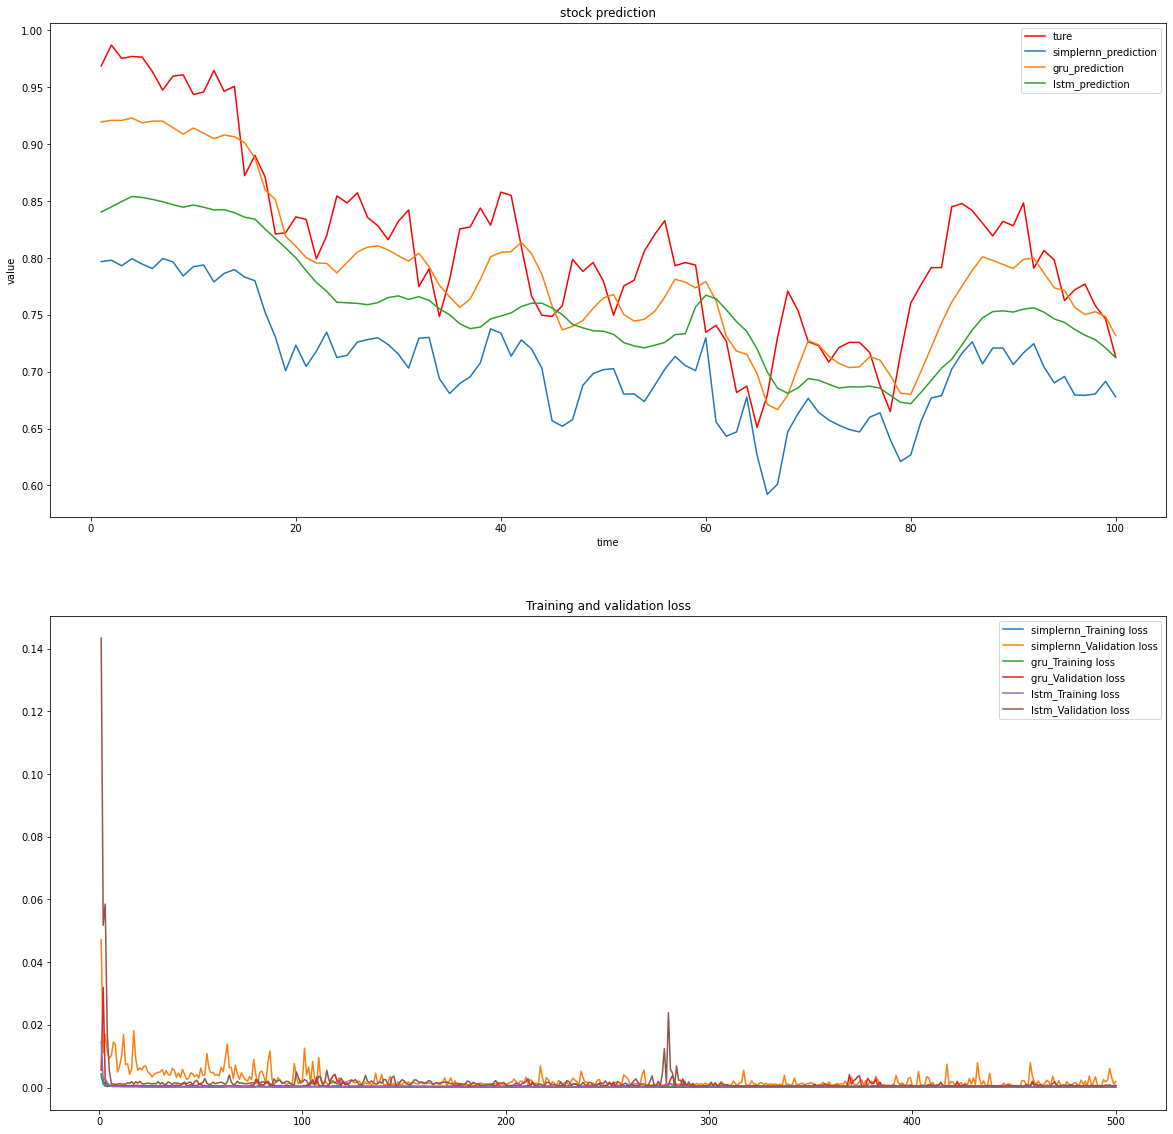

In [182]:

plt.figure(figsize = (20,20))
for index,(prediction_Y ,history) in enumerate(zip(predict,his)):
  visual_y=[]
  visual_pre_y=[]
  for i in range(len(prediction_Y)):
    label = Y_test[i]
    prediction = prediction_Y[i]
    visual_y.append(label)
    visual_pre_y.append(prediction)
  plt.subplot(2,1,1)
  time = range(1, len(visual_y) + 1)
  if index ==0:
    plt.plot(time, visual_y, 'r', label='ture')
  plt.plot(time, visual_pre_y, label=f'{name[index]}_prediction')
  plt.title('stock prediction')
  plt.xlabel('time')
  plt.ylabel('value')
  plt.legend()
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)
  plt.subplot(2,1,2)
  plt.plot(epochs, loss, label=f'{name[index]}_Training loss')
  plt.plot(epochs, val_loss, label=f'{name[index]}_Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
plt.show()

In [183]:
# CNN + RNN
input_Layer = tf.keras.layers.Input(shape=(seq_length, x_data_dim))
x = tf.keras.layers.Conv1D(32, kernel_size = 1, activation='tanh')(input_Layer)
x = tf.keras.layers.LSTM(50, activation='tanh')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(50, activation='relu')(x)
Out_Layer= tf.keras.layers.Dense(1, activation=None)(x)
model_6 = tf.keras.Model(inputs=[input_Layer], outputs=[Out_Layer])
model_6.summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 8, 4)]            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 8, 32)             160       
_________________________________________________________________
lstm_27 (LSTM)               (None, 50)                16600     
_________________________________________________________________
dense_109 (Dense)            (None, 100)               5100      
_________________________________________________________________
dense_110 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 51        
Total params: 26,961
Trainable params: 26,961
Non-trainable params: 0
______________________________________________________

In [184]:
model_6.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),  loss= 'mse',metrics = [keras.metrics.mean_absolute_error])
epoch = 500
batch_size = 100
history_6 = model_6.fit(data_gen_train, epochs = epoch, verbose  = 1, validation_data = data_gen_val)

Epoch 1/500
8/8 [==============================] - 3s 87ms/step - loss: 0.0185 - mean_absolute_error: 0.1060 - val_loss: 0.1182 - val_mean_absolute_error: 0.3301
Epoch 2/500
8/8 [==============================] - 0s 13ms/step - loss: 0.0041 - mean_absolute_error: 0.0557 - val_loss: 0.0356 - val_mean_absolute_error: 0.1754
Epoch 3/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0014 - mean_absolute_error: 0.0292 - val_loss: 0.0447 - val_mean_absolute_error: 0.2007
Epoch 4/500
8/8 [==============================] - 0s 13ms/step - loss: 0.0010 - mean_absolute_error: 0.0236 - val_loss: 0.0103 - val_mean_absolute_error: 0.0884
Epoch 5/500
8/8 [==============================] - 0s 14ms/step - loss: 6.2933e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0073 - val_mean_absolute_error: 0.0733
Epoch 6/500
8/8 [==============================] - 0s 17ms/step - loss: 3.9239e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0020 - val_mean_absolute_error: 0.0337
Epoch 7/500
8/8 [===

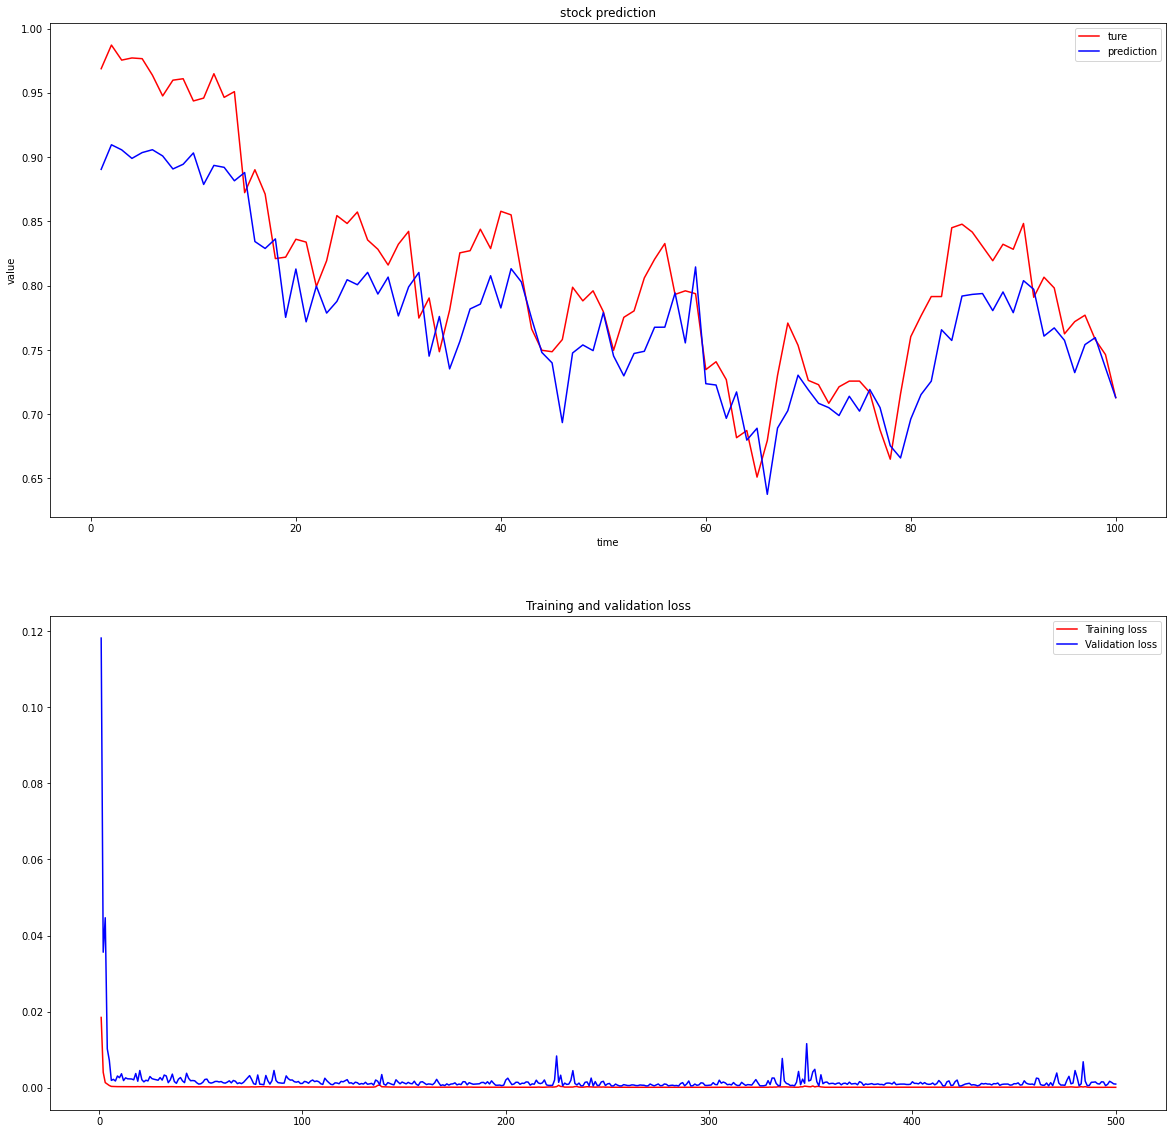

In [186]:
test_data_X, test_data_Y=data_gen_test[0]
prediction_Y=model_6.predict(test_data_X).flatten()
Y_test=test_data_Y.flatten()

visual_y=[]
visual_pre_y=[]
for i in range(len(prediction_Y)):
    label = Y_test[i]
    prediction = prediction_Y[i]
    visual_y.append(label)
    visual_pre_y.append(prediction)
plt.figure(figsize = (20,20))
time = range(1, len(visual_y) + 1)
plt.subplot(2,1,1)
plt.plot(time, visual_y, 'r', label='ture')
plt.plot(time, visual_pre_y, 'b', label='prediction')
plt.title('stock prediction')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()

loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()